In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# grAdapt
import grAdapt
from grAdapt.models import Sequential
from grAdapt.space.datatype import Integer, Float, Categorical

## 1. Introduction
This is a tutorial how to use **grAdapt**. The package itself is much more powerful and there are many possibilites to use this package. This notebook briefly introduces how to optimize blackbox functions. We will take a look at tuning hyperparameters for classification tasks.

### 1.1 Data Set
For the data set, we will use the **NIST data set** as it is small enough to train a classifier fast on it. Though the nature of the developed package is to optimize of float variables, we will take a look at integer and categorical optimization.

### 1.2 Hyperparameter Optimization
For demonstration, we will tune the hyperparameters for k-Nearest Neighbor and the Support Vector Machine. The k-Nearest Neighbor algorithm requires one hyperparameter. To show that grAdapt works with multiple input dimensions, three hyperparameters of the Support Vector Machine will be tuned where each hyperparameter can have a different type than the other.

#### Load MNIST data set

In [2]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

print(data.shape)

# Split data into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(
    data, digits.target, test_size=0.8, shuffle=False)

(1797, 64)


## 2. Define Blackbox

The intuition behind defining a blackbox function it to fit the classifier to the training set and then returning the validation accuracy. The validation accuracy is to be maximized and the input variables of the blackbox function are the hyperparameters to be optimized. The hyperparameters are set when creating a classifier instance.

In [3]:
def knn_opt(n):
    # create KNN instance
    neigh = KNeighborsClassifier(n_neighbors=n)
    
    # fit/train
    neigh.fit(X_train, y_train)
    
    # return validation accuracy
    return neigh.score(X_val, y_val)

In [4]:
def svm_opt(C, gamma, kernel):
    # create SVM instance
    clf = svm.SVC(C=C, gamma=gamma, kernel=kernel)
    
    # fit/train
    clf.fit(X_train, y_train)
    
    # return validation accuracy
    return clf.score(X_val, y_val)

## 3. Hyperparameter Optimization with grAdapt

In this section, we are creating a **grAdapt Sequential** model. For brevity, settings of the Sequential model are not demonstrated. We will also take a look how to define search spaces by using **grAdapt Datatypes**.

### 3.1 k-Nearest Neighbor

k-Nearest Neighbor takes one hyperparameter which is the number of neighbors *n*. Because the number of neighbors is an integer, we are doing **integer programming**.

In [5]:
# create base model
model = Sequential()

# create bounds
bounds = [Integer(low=1, high=100)]

Optimize *knn_opt* function by the given *bounds*. Evaluate the blackbox function at most *500* times.

In [6]:
res = model.maximize_args(knn_opt, bounds, 500, show_progressbar=True)

Sampling 1 random points.
Random function evaluations. This might take a while.


  1%|▎                                         | 3/500 [00:00<00:28, 17.71it/s]

Finding optimum...


100%|████████████████████████████████████████| 500/500 [01:12<00:00,  6.88it/s]


**res** is a dictionary. The history can be accessed as in the following where
*x* contains the history of the hyperparameter settings and *y* contains the history of the validation accuracy.

In [7]:
y_knn = res['y']
x_knn = res['x']

#### 3.1.1 Training Plot

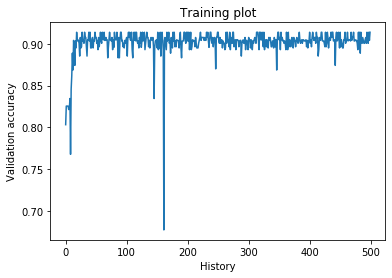

In [8]:
plt.plot(np.arange(y_knn.shape[0]), y_knn)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('Validation accuracy')
plt.show()

#### 3.1.2 Hyperparameter Plot

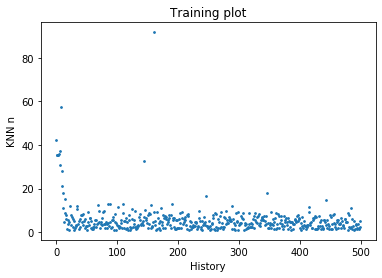

In [9]:
plt.scatter(np.arange(x_knn.shape[0]), x_knn, s=3)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('KNN n')
plt.show()

#### 3.1.3 Best Hyperparameter

In [10]:
x_knn_sol = res['x_sol']
y_knn_sol = res['y_sol']
print(x_knn_sol)
print(y_knn_sol)

[1.51820671]
0.913769123783032


Internally grAdapt uses floats and thus returns floats. To obtain the optimal hyperparameter when having integer variables, we have to manually round these. The real solution is then:

In [11]:
np.round(x_knn_sol)

array([2.])

with the achieved validation accuracy of:

In [12]:
print(y_knn_sol)

0.913769123783032


#### 3.1.4 Results

grAdapt slowly decreases *n* as this setting improves the performance. grAdapt still escapes from the local optima but higher values led to poor performances. Thus, the chances of obtaining higher values of *n* is decreased but not vanished (to ensure a global solution). A variation of *n* can be obtained through the whole history. It is very unlikely for grAdapt to obtain the same values twice (internally).

### 3.2 Support Vector Machine

Support Vector Machine takes three hyperparameters which are *C*, *gamma* and the *kernel* function. Both *C* and *gamma* are float variables. The last hyperparameter is a categorical variable which is a list of strings.

In [13]:
# create base model
model = Sequential()

# create bounds
c_var = Float(low=1e-3, high=100)
gamma_var = Float(low=1e-3, high=1e3)
kernel_var = Categorical(['linear', 'poly', 'sigmoid', 'rbf'])
bounds = [c_var, gamma_var, kernel_var]

In [14]:
res_svm = model.maximize_args(svm_opt, bounds, 500, show_progressbar=True)

  0%|                                                  | 0/500 [00:00<?, ?it/s]

Sampling 58 random points.
Random function evaluations. This might take a while.
(8, 3)
(50, 3)


 12%|█████                                    | 61/500 [00:00<00:15, 29.14it/s]

Finding optimum...


100%|████████████████████████████████████████| 500/500 [00:52<00:00,  9.60it/s]


In [15]:
y_svm = res_svm['y']
x_svm = res_svm['x']

#### 3.2.1 Training Plot

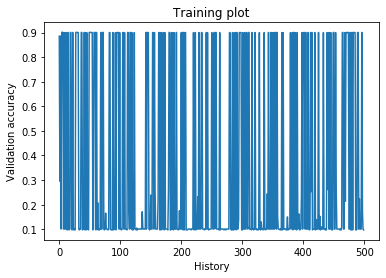

In [16]:
plt.plot(np.arange(y_svm.shape[0]), y_svm)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('Validation accuracy')
plt.show()

#### 3.2.2 Hyperparameter Plot

##### 3.2.2.1 C value

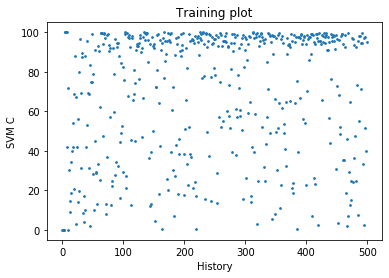

In [17]:
plt.scatter(np.arange(x_svm.shape[0]), x_svm[:,0], s=3)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('SVM C')
plt.show()

##### 3.2.2.2 gamma value

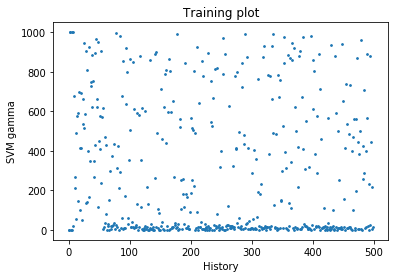

In [18]:
plt.scatter(np.arange(x_svm.shape[0]), x_svm[:,1], s=3)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('SVM gamma')
plt.show()

##### 3.2.2.3 kernel

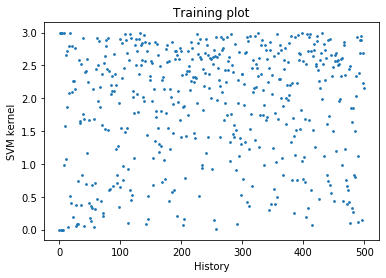

In [19]:
plt.scatter(np.arange(x_svm.shape[0]), x_svm[:,2], s=3)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('SVM kernel')
plt.show()

#### 3.2.3 Best Hyperparameters

In [20]:
x_svm_sol = res_svm['x_sol']
y_svm_sol = res_svm['y_sol']
print(x_svm_sol)
print(y_svm_sol)

[1.e+02 1.e-03 3.e+00]
0.9012517385257302


Real solutions:

In [21]:
x_svm_sol = x_svm_sol.tolist()
x_svm_sol[2] = kernel_var.get_category(x_svm_sol[2])

In [22]:
x_svm_sol

[100.0, 0.001, 'rbf']

#### 3.2.4 Results

Optimizing three hyperparameters at once does not seem to be a problem for grAdapt. Even if the hyperparameters are of different datatypes (float+categorical).

It can be obtained that high *C* and low *gamma* values led to good performances. grAdapt often escapes but also stays local when good solutions were found. For the categorical variable, it can not be read which kernel function led to good performances. It seems that the kernel function is less important for the specific data set.

Because each variable can influence each other, it is astonishing to see that grAdapt handles this well and has found good settings for each parameter.